# Time Series Forecasting with Deep Learning in PyTorch (LSTM-RNN)
https://towardsdatascience.com/time-series-forecasting-with-deep-learning-in-pytorch-lstm-rnn-1ba339885f0c

A time series is any quantifiable metric or event that takes place over a period of time. There is a frequency of the event (daily, weekly, hourly, etc.) and a length of time over which the event takes place repeatedly (a month, year, day, etc.). For a time series, the metric is recorded with a uniform frequency throughout the length of time over which we are observing the metric. The time in between each record should be the same.

#### Objective
Take in a sequence of values and predict the next value in the sequence.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from PslpDataset import PSLPDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler

### Load data

In [2]:
api_key = "6e68642c-8403-4caa-af31-bda40b8c67f6" # web token for RESTful API
country_code = "10Y1001A1001A83F" # Germany
time_zone = "Europe/Berlin" # time zone for Germany
start_date = "20180101"
end_date = "20180601"
downsample = False
pslp = False

In [3]:
PslpData = PSLPDataset(start_date, 
                       end_date, 
                       api_key, 
                       country_code, 
                       time_zone, 
                       downsample=downsample,
                       pslp=pslp,
                      )

Consider the following dates:
0   2018-01-01
1   2018-06-01
dtype: datetime64[ns]
Trying to load data chunk for time interval [2018-01-01 00:00:00, 2018-06-01 00:00:00]...
Actual load has shape (14492, 1).
Actual generation per production type has shape (14492, 24).
Concatenated data frame has shape (14492, 25).
(14492, 25)
Loading successful!
Dropping columns containing actual consumption...
Returning final data frame...


### Scale data

In [4]:
#print(PslpData.df.columns)
print(PslpData.df['Actual Load'])
print(PslpData.df.to_numpy().flatten().shape)
print(PslpData.df.to_numpy()[:,0])
#df = PslpData.df[PslpData.original_headers].to_frame()
#print(df.columns)

2018-01-01 00:00:00+01:00    46042.0
2018-01-01 00:15:00+01:00    45525.0
2018-01-01 00:30:00+01:00    45173.0
2018-01-01 00:45:00+01:00    44993.0
2018-01-01 01:00:00+01:00    44695.0
                              ...   
2018-05-31 21:45:00+01:00    50742.0
2018-05-31 22:00:00+01:00    49775.0
2018-05-31 22:15:00+01:00    48941.0
2018-05-31 22:30:00+01:00    47835.0
2018-05-31 22:45:00+01:00    47061.0
Freq: 15T, Name: Actual Load, Length: 14492, dtype: float64
(260856,)
[46042. 45525. 45173. ... 48941. 47835. 47061.]


In [5]:
def scale_data(df, individual=True):
    """
    Scale input data.
    Params
    ------
    df : pandas.DataFrame
         Data to scale.
    individual : bool
                 Scale each feature individually or not.
    Returns
    -------
    numpy.array : Scaled data.
    """
    
    if individual is True:
        print("Scale each feature individually.")
        norm_df = pd.DataFrame(MinMaxScaler().fit_transform(df.to_numpy(dtype=float)))
        norm_df.columns = df.columns
            
    else:
        print("Scale features globally.")
        norm_df = df.copy() # Copy original data frame for storing scaled data.
        scaler = MinMaxScaler().fit(df.to_numpy(dtype=float).flatten().reshape(-1, 1))
        for x in df.columns:
            norm_df[x] = scaler.transform(df[x].to_numpy(dtype=float).reshape(-1, 1))
    return norm_df

In [6]:
norm_df = scale_data(PslpData.df, individual=False)

Scale features globally.


In [7]:
norm_arr = norm_df.to_numpy()
print(np.amin(norm_arr, axis=0), np.amax(norm_arr, axis=0))
for i in range(norm_arr.shape[1]):
    print(np.amin(norm_arr[:, i]), np.amax(norm_arr[:,i]))

[4.12618959e-01 4.80163144e-02 6.65059943e-02 2.68199234e-03
 1.05549376e-02 1.32492893e-02 1.68087999e-03 1.35953529e-04
 0.00000000e+00 1.48436534e-02 3.58422939e-04 5.60252132e-02
 3.32468175e-03 1.76739587e-03 0.00000000e+00 3.04041528e-03
 2.47188234e-05 1.91570881e-03] [1.00000000e+00 6.18094179e-02 2.27994067e-01 7.60103819e-03
 1.60795946e-01 2.14806575e-01 8.98529230e-03 3.46063527e-04
 9.11753801e-02 3.56321839e-02 1.49548881e-03 1.16907675e-01
 5.99555061e-02 2.73142998e-03 3.56247683e-01 9.61562230e-03
 6.14633543e-02 4.74922754e-01]
0.4126189593375355 1.0
0.048016314423433445 0.06180941787170931
0.06650599431467062 0.22799406748238785
0.0026819923371647508 0.007601038190582128
0.010554937584970956 0.16079594611296502
0.01324928933382771 0.21480657520702015
0.0016808799901124707 0.008985292300086515
0.00013595352861203806 0.00034606352737609686
0.0 0.09117538005190953
0.014843653442096157 0.035632183908045977
0.00035842293906810036 0.0014954888147324188
0.05602521319985169 

In [8]:
print(norm_df.iloc[1])

Actual Load                                          0.562662
Biomass Actual Aggregated                            0.058151
Fossil Brown coal/Lignite Actual Aggregated          0.082956
Fossil Coal-derived gas Actual Aggregated            0.006242
Fossil Gas Actual Aggregated                         0.029799
Fossil Hard coal Actual Aggregated                   0.021308
Fossil Oil Actual Aggregated                         0.002311
Geothermal Actual Aggregated                         0.000309
Hydro Pumped Storage Actual Aggregated               0.003028
Hydro Run-of-river and poundage Actual Aggregated    0.021629
Hydro Water Reservoir Actual Aggregated              0.000556
Nuclear Actual Aggregated                            0.073613
Other Actual Aggregated                              0.005376
Other renewable Actual Aggregated                    0.001780
Solar Actual Aggregated                              0.000000
Waste Actual Aggregated                              0.008058
Wind Off

### Sequencing
After scaling the data and making sure it has uniform frequency (resampling otherwise), make clips or sequences of fixed length from time series. While recording these sequences, also record the value occurring right after that sequence as the corresponding target. E.g., consider $\left[1, 2, 3, 4, 5, 6\right]$. Choosing a sequence length of three, generate the following sequences and their associated targets:

$$\mathbf{[Sequence]\rightarrow\ Target}\\
[1,2,3]\rightarrow 4\\
[2,3,4]\rightarrow 5\\
[3,4,5]\rightarrow 6$$

Another way to look at this is that we define how many steps to look back to predict the next value. Call this value the **training window** (also `lookback`) and the number of values to predict the **prediction window** (also `forecast`). In this example, they are 3 and 1, respectively.

In my data frame, the rows are the actual samples.

In [9]:
def generate_sequences(df: pd.DataFrame, tw: int, pw: int, target_columns, drop_targets=False):
    """
    Create sequences from univariate time series.
    Params
    ------
    df: pd.DataFrame
        time series data
    tw: int
        training window defining how many steps to look back
    pw: int
        prediction Window defining how many steps forward to predict
  
    Returns
    -------
    Dictionary of sequences and targets.
    """
    data = dict() # Store results in nested dict.
    for i in range(len(df) - tw):
        # Get current sequence  
        sequence = df[i:i+tw].to_numpy(dtype=float)
        # Get values right after the current sequence
        target = df[i+tw:i+tw+pw].to_numpy(dtype=float)
        data[i] = {'sequence': sequence, 'target': target}
    return data

In [10]:
class SequenceDataset(data.Dataset):
    """
    PyTorch dataset for sequenced time series data.
    """
    def __init__(self, data):
        """
        Constructor.
        Params
        ------
        data : dict
               Dictionary of sequences and targets
        """
        self.data = data
  
    def __getitem__(self, idx):
        sample = self.data[idx]
        return torch.Tensor(sample['sequence']), torch.Tensor(sample['target'])
    
    def __len__(self):
        return len(self.data)

Use `PyTorch` DataLoader to iterate through the data. The benefit of using a DataLoader is that it handles batching and shuffling internally. Now prepare training batches. At each iteration, the DataLoader will yield `batch_size` sequences with their associated targets which will be passed into the model.

In [11]:
bs = 16 # training batch size
split = 0.8 # train-test split ratio

tw = 96
pw = 1
n_features = len(norm_df.columns)
sequences = generate_sequences(norm_df, tw, pw, 'Actual Load')
dataset = SequenceDataset(sequences)

# Split data according to split ratio and load each subset into separate DataLoader.
train_len = int(len(dataset) * split)
lens = [train_len, len(dataset) - train_len]
train_ds, test_ds = torch.utils.data.dataset.random_split(dataset, lens)
trainloader = data.DataLoader(train_ds, 
                              batch_size=bs, 
                              shuffle=True, 
                              drop_last=True
                             )
testloader = data.DataLoader(test_ds, 
                             batch_size=bs, 
                             shuffle=True, 
                             drop_last=True
                            )
for train_samples, train_labels in trainloader:  
    print(f"First train sample in batch of shape {train_samples.shape}: {train_samples[0]}")
    print(f"First train label in batch of shape {train_labels.shape}: {train_labels[0]}")
    break
print("Data has shape (batch size, sequence length, features).")

First train sample in batch of shape torch.Size([16, 96, 18]): tensor([[0.7239, 0.0600, 0.2197,  ..., 0.0076, 0.0143, 0.0425],
        [0.7212, 0.0601, 0.2198,  ..., 0.0077, 0.0141, 0.0407],
        [0.7241, 0.0600, 0.2202,  ..., 0.0077, 0.0130, 0.0389],
        ...,
        [0.6750, 0.0594, 0.2129,  ..., 0.0076, 0.0015, 0.0175],
        [0.6721, 0.0597, 0.2132,  ..., 0.0077, 0.0016, 0.0172],
        [0.6674, 0.0598, 0.2130,  ..., 0.0076, 0.0017, 0.0160]])
First train label in batch of shape torch.Size([16, 1, 18]): tensor([[6.6621e-01, 5.9820e-02, 2.1282e-01, 6.1426e-03, 3.3531e-02, 8.7604e-02,
         2.3606e-03, 2.9663e-04, 5.2033e-03, 2.1790e-02, 8.6516e-04, 1.1648e-01,
         5.0587e-02, 2.5708e-03, 2.1345e-02, 7.7246e-03, 1.6809e-03, 1.4757e-02]])
Data has shape (batch size, sequence length, features).


In [12]:
print(train_ds.__getitem__(0)[0].shape)
print(train_ds.__getitem__(0)[1].shape)

torch.Size([96, 18])
torch.Size([1, 18])


### Model Architecture
The class below defines the model architecture in `PyTorch`. Use a single LSTM layer, followed by some dense layers for the regressive part of the model with dropout layers in between them. The model will output a single value for each training input. 

## LSTM
CLASS `torch.nn.LSTM(*args, **kwargs)`  
Applies a multi-layer long short-term memory (LSTM) RNN to an input sequence.

For each element in the input sequence, each layer computes the following function:

$$i_t=\sigma\left(W_{ii}x_t+b_{ii}+W_{hi}h_{t-1}+b_{hi}\right)\\
f_t=\sigma\left(W_{if}x_t+b_{if}+W_{hf}h_{t-1}+b_{hf}\right)\\
g_t=\tanh{\left(W_{ig}x_t+b_{ig}+W_{hg}h_{t-1}+b_{hg}\right)}\\
o_t=\sigma\left(W_{io}x_t+b_{io}+W_{ho}h_{t-1}+b_{ho}\right)\\
c_t=f_t\odot c_{t-1}+i_t\odot g_t\\
h_t=o_t\odot \tanh{\left(c_t\right)}$$

$h_t$ is the hidden state at time $t$, $c_t$ is the cell state at time $t$, $x_t$ is the input at time t, $h_{t-1}$ is the hidden state of the layer at time $t-1$ or the initial hidden state at time $0$, and $i_t$, $f_t$, $g_t$, $o_t$ are the input, forget, cell, and output gates, respectively. $\sigma$ is the sigmoid function and $\odot$ is the Hadamard product.

In a multilayer LSTM, the input $x_t^{(l)}$ of the $l$-th layer ($l\geq 2$) is the hidden state $h_t^{l-1}$ of the previous layer multiplied by dropout $\delta_t^{(l-1)}$ where each $\delta_t^{(l-1)}$ is a Bernoulli random variable which is $0$ with probability `dropout`.

### Parameters
- **`input_size`** – The number of expected features in the input $x$. Adapt this for multivariate inputs?
- **`hidden_size`** – The number of features in the hidden state $h$
- **`num_layers`** – Number of recurrent layers. E.g. setting `num_layers=2` would mean stacking two LSTMs together to form a *stacked* LSTM, with the second LSTM taking in outputs of the first LSTM and computing the final result. Default: 1
- **`bias`** – If `False`, the layer does not use bias weights `b_ih` and `b_hh`. Default: `True`
- **`batch_first`** – If `True`, the input and output tensors are provided as *(batch, seq, feature)* instead of *(seq, batch, feature)*- This does not apply to hidden or cell states. Default: `False`
- **`dropout`** – If non-zero, introduces a *Dropout* layer on the outputs of each LSTM layer except the last layer, with dropout probability equal to `dropout`. Default: 0
- **`bidirectional`** – If `True`, becomes a bidirectional LSTM. Default: `False`

### Inputs: input, (h_0, c_0)
- **`input`** : tensor of shape $\left(L, H_{in}\right)$ for unbatched input, $\left(L,N,H_{in}\right)$ when `batch_first=False` or $\left(N,L,H_{in}\right)$ when `batch_first=True` containing the features of the input sequence.
- **`h_0`** : tensor of shape $\left(D*num\_layers,H_{out}\right)$ for unbatched input or $\left(D*num\_layers,N,H_{out}\right)$ containing the initial hidden state for each element in the input sequence. Defaults to zeros if `(h_0, c_0)` is not provided.
- **`c_0`** : tensor of shape $\left(D*num\_layers, H_{cell}\right)$ for unbatched input or $\left(D*num\_layers, N, H_{cell}\right)$ containing the initial cell state for each element in the input sequence. Defaults to zeros if `(h_0, c_0)` is not provided.

with

- $N$ – batch size
- $L$ – sequence length
- $D$ – 2 if `bidirectional` otherwise 1
- $H_{in}$ – input_size
- $H_{cell}$ – hidden_size
- $H_{out}$ – hidden_size

### Outputs: output, (h_n, c_n)
- **`output`** : tensor of shape $\left(L, D*H_{out}\right)$ for unbatched input, $\left(L, N D*H_{out}\right)$ when `batch_first=False` or $\left(N, L, D*H_{out}\right)$ when `batch_first=True` containing the output features *(h_t)* from the last layer of the LSTM, for each t.
- **`h_n`** : tensor of shape $\left(D*num\_layers, H_{out}\right)$ for unbatched input or $\left(D*num\_layers, N, H_{out}\right)$ containing the final hidden state for each element in the sequence.
- **`c_n`** : tensor of shape $\left(D*num\_layers, H_{cell}\right)$ for unbatched input or $\left(D*num\_layers, N, H_{cell}\right)$ containing the final cell state for each element in the sequence.

### Variables:
- **`weight_ih_l[k]`** – the learnable input-hidden weights of the $k^\text{th}$ layer *(W_ii|W_if|W_ig|W_io)* of shape *(4*hidden_size, input_size)* for *k=0*. Otherwise, the shape is *(4*hidden_size, num_directions*hidden_size)*.
- **`weight_hh_l[k]`** – the learnable hidden-hidden weights of the $k^\text{th}$ layer *(W_hi|W_hf|W_hg|W_ho)* of shape *(4*hidden_size, hidden_size)*.
- **`bias_ih_l[k]`** – the learnable input-hidden bias of the $k^\text{th}$ layer *(b_ii|b_if|b_ig|b_io)* of shape *(4*hidden_size)*.
- **`bias_hh_l[k]`** – the learnable hidden-hidden bias of the $k^\text{th}$ layer *(b_hi|b_hf|b_hg|b_ho)* of shape *(4*hidden_size)*.

## LSTMCELL
CLASS `torch.nn.LSTMCell(input_size, hidden_size, bias=True, device=None, dtype=None)`  

A long short-term memory (LSTM) cell.

$$i=\sigma\left(W_{ii}x+b_{ii}+W_{hi}h+b_{hi}\right)\\
f=\sigma\left(W_{if}x+b_{if}+W_{hf}h+b_{hf}\right)\\
g=\tanh{\left(W_{ig}x+b_{ig}+W_{hg}h+b_{hg}\right)}\\
o=\sigma\left(W_{io}x+b_{io}+W_{ho}h+b_{ho}\right)\\
c'=f\odot c+ i\odot g\\
h'=o\odot \tanh{c'}$$

$\sigma$ is the sigmoid function and $\odot$ the Hadamard product.

### Parameters
- **`input_size`** *(int)* – The number of expected features in the input $x$
- **`hidden_size`** *(int)* – The number of features in the hidden state $h$
- **`bias`** *(bool)* – If `False`, the layer does not use bias weights *b_ih* and *b_hh*. Default: `True`

### Inputs: input, (h_0, c_0)
- **`input`** of shape *(batch, input_size)* or *(input_size)*: tensor containing input features
- **`h_0`** of shape *(batch, hidden_size)* or *(hidden_size)*: tensor containing the initial hidden state
- **`c_0`** of shape *(batch, hidden_size)* or *(hidden_size)*: tensor containing the initial cell state

If *(h_0, c_0)* is not provided both default to zero.

### Outputs: (h_1, c_1)
- **`h_1`** of shape *(batch_size, hidden_size)* or *(hidden_size)*: tensor containing the next hidden state
- **`c_1`** of shape *(batch_size, hidden_size)* or *(hidden_size)*: tensor containing the next cell state

### Variables
- **`weight_ih`** *(torch.Tensor)* – the learnable input-hidden weights of shape *(4*hidden_size, input_size)*
- **`weight_hh`** *(torch.Tensor)* – the learnable hidden-hidden weights of shape *(4*hidden_size, hidden_size)*
- **`bias_ih`** – the learnable input-hidden bias of shape *(4*hidden_size)*
- **`bias_hh`** – the learnable hidden-hidden bias of shape *(4*hidden_size)*

`LSTMCell` is a cell that takes arguments:
- input of shape *batch x input dimension*
- a tuple of LSTM hidden states of shape *batch x hidden dimensions*  
It is a straight-forward implementation of the equations.

`LSTM` is a layer applying an LSTM cell (or multiple LSTM cells) in a "for loop", but the loop is heavily optimized using cuDNN. Its inputs are:
- a 3D tensor of inputs of shape *batch x input length x input dimension*
- optionally, an initial state of the LSTM, i.e., a tuple of hidden states of shape *batch x hidden dimension*  
You often might want to use the LSTM cell in a different context than apply it over a sequence, i.e., make an LSTM that operates over a tree-like structure. When you write a decoder in sequence-to-sequence models, you also call the cell in a loop and stop the loop when the end-of-sequence symbol is decoded.

So `LSTMCell` takes **one** input $x_t$. Need to make a loop in order to do one pass of backprop through time. `LSTM` takes a **sequence** of inputs $\left(x_0, x_1, ..., x_T\right)$. No need to write a loop to do one pass of backprop through time. 
`LSTMCell` is the building block of `LSTM`. In `LSTM`, there are multiple `LSTMCell` instances in one layer, where the number of instances equals the sequence or unrolling length of the network.

In [16]:
class LSTMForecaster(nn.Module):

    def __init__(self, 
                 n_features, 
                 n_hidden, 
                 n_outputs, 
                 sequence_len, 
                 n_lstm_layers=1, 
                 n_deep_layers=10, 
                 device=None, 
                 dropout=0.2
                ):
        """
        Constructor of LSTM RNN.
        Params
        ------
        n_features : int
                     number of input features (1 for univariate forecasting)
        n_hidden : int
                   number of neurons in each hidden layer
        n_outputs : int
                    number of outputs to predict for each training example
        sequence_len : int
                       number of steps to look back for prediction
        n_lstm_layers : int
                        number of LSTM layers
        n_deep_layers : int
                        number of hidden dense layer(s) after LSTM layer(s)
        device : torch.device
                 device to use
        dropout : float 
                  dropout ratio between dense layers, 0 < dropout < 1
        """
        super().__init__()
   
        self.n_lstm_layers = n_lstm_layers
        self.nhid = n_hidden
        self.device = device # set option for device selection
   
         # LSTM part
        self.lstm = nn.LSTM(input_size=n_features, # number of expected features in input x
                            hidden_size=n_hidden, # number of features in hidden state h
                            num_layers=n_lstm_layers, # number of recurrent layers
                            batch_first=True # data is transformed in this way
                           ) 
        
        # First dense layer after LSTM
        self.fc1 = nn.Linear(in_features=n_hidden * sequence_len, # size of each input sample
                             out_features=n_hidden # size of each output sample
                            ) 
        # Dropout layer
        self.dropout = nn.Dropout(p=dropout)
   
        # Create fully connected layers (n_hidden x n_deep_layers)
        fc_layers = []
        for i in range(n_deep_layers):
          # Last layer (n_hidden x n_outputs)
          if i == n_deep_layers - 1:
            fc_layers.append(nn.ReLU())
            fc_layers.append(nn.Linear(in_features=n_hidden, 
                                       out_features=n_outputs
                                      )
                            )
          # All other layers (n_hidden x n_hidden) with dropout option.
          else:
            fc_layers.append(nn.ReLU())
            fc_layers.append(nn.Linear(in_features=n_hidden, 
                                       out_features=n_hidden
                                       )
                            )
            if dropout:
                fc_layers.append(nn.Dropout(p=dropout))
        # Compile FC layers
        self.fc = nn.Sequential(*fc_layers)
  
    def forward(self, x):
  
        # Initialize hidden state and cell state.
        hidden_state = torch.zeros(self.n_lstm_layers, x.shape[0], self.nhid)
        cell_state = torch.zeros(self.n_lstm_layers, x.shape[0], self.nhid)
  
        # Move hidden state to device.
        hidden_state = hidden_state.to(device)
        cell_state = cell_state.to(device)
           
        self.hidden = (hidden_state, cell_state)
  
        # Forward Pass
        x, h = self.lstm(x, self.hidden) # LSTM
        x = self.dropout(x.contiguous().view(x.shape[0], -1)) # Flatten LSTM output. 
        x = self.fc1(x) # First dense layer.
        return self.fc(x) # Pass forward through fully connected DNN.

In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device.")

n_hidden = 72 # Number of nodes in the hidden layer
n_deep_layers = 5 # Number of hidden fully connected layers
n_lstm_layers = 1 # Number of LSTM layers

# Initialize model.
model = LSTMForecaster(
                 n_features=n_features, 
                 n_hidden=n_hidden, 
                 n_outputs=n_features, 
                 sequence_len=tw, 
                 n_lstm_layers=n_lstm_layers, 
                 n_deep_layers=n_deep_layers, 
                 device=device, 
                 dropout=0.2).to(device)

Using cpu device.


In [25]:
# Set learning rate and number of epochs to train over
lr = 4e-4
n_epochs = 100

# Initialize the loss function and optimizer
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

In [26]:
# Lists to store training and validation losses.
t_losses, v_losses = [], []
# Loop over epochs.
for epoch in range(n_epochs):
    train_loss, valid_loss = 0.0, 0.0
  
    # train step
    model.train()
    # Loop over train dataset
    for x, y in trainloader:
        optimizer.zero_grad()
        # move inputs to device
        x = x.to(device)
        y  = y.squeeze().to(device)
        # Forward Pass
        preds = model(x).squeeze()
        loss = criterion(preds, y) # compute batch loss
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    epoch_loss = train_loss / len(trainloader)
    t_losses.append(epoch_loss)
    
    # Validation step
    model.eval()
    # Loop over validation dataset
    for x, y in testloader:
        with torch.no_grad():
            x, y = x.to(device), y.squeeze().to(device)
            preds = model(x).squeeze()
            error = criterion(preds, y)
        valid_loss += error.item()
    valid_loss = valid_loss / len(testloader)
    v_losses.append(valid_loss)
        
    print(f"Epoch {epoch}: Train loss is {epoch_loss}, validation loss is {valid_loss}.")

Epoch 0: Train loss is 0.00018064296874071968, validation loss is 8.746944590206516e-05.
Epoch 1: Train loss is 0.00018088322320887598, validation loss is 8.716743084530915e-05.
Epoch 2: Train loss is 0.00017901270298409678, validation loss is 8.191924807761097e-05.
Epoch 3: Train loss is 0.00018004067959216967, validation loss is 8.139459381103127e-05.
Epoch 4: Train loss is 0.00017748041416967535, validation loss is 9.172884242111144e-05.
Epoch 5: Train loss is 0.0001766109337334156, validation loss is 7.541884466869912e-05.
Epoch 6: Train loss is 0.00017738346894612011, validation loss is 8.880334955594865e-05.
Epoch 7: Train loss is 0.00017907270567131555, validation loss is 7.9301650617304e-05.
Epoch 8: Train loss is 0.00017685906633322474, validation loss is 8.086203654076801e-05.
Epoch 9: Train loss is 0.00017450357570469326, validation loss is 7.666975737568767e-05.
Epoch 10: Train loss is 0.00017610327089292817, validation loss is 7.782687876493179e-05.
Epoch 11: Train loss is

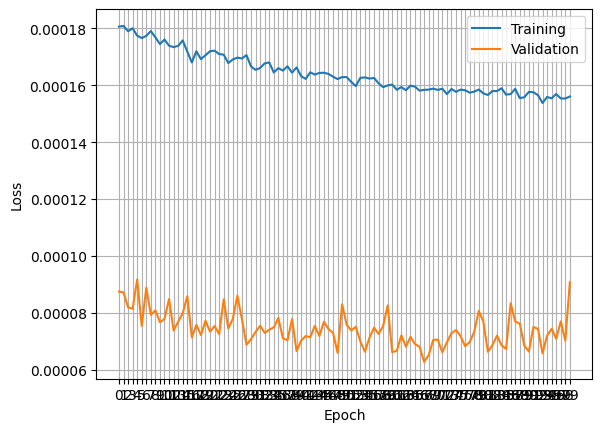

In [27]:
plt.plot(t_losses, label="Training")
plt.plot(v_losses, label="Validation")
plt.xlabel("Epoch")
plt.xticks(list(range(n_epochs)))
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

In [ ]:
def make_predictions_from_dataloader(model, unshuffled_dataloader):
    model.eval()
    predictions, actuals = [], []
    for x, y in unshuffled_dataloader:
        with torch.no_grad():
            p = model(x)
            predictions.append(p)
            actuals.append(y.squeeze())
    predictions = torch.cat(predictions).numpy()
    actuals = torch.cat(actuals).numpy()
    return predictions.squeeze(), actuals

In [ ]:
trainloader_noshuffle = data.DataLoader(train_ds, 
                                        batch_size=bs, 
                                        shuffle=False, 
                                        drop_last=True
                                       )
testloader_noshuffle = data.DataLoader(test_ds, 
                                       batch_size=bs, 
                                       shuffle=False, 
                                       drop_last=True
                                      )
preds, actual = make_predictions_from dataloader(model, )

### Forecasting
If we define history as the series until the moment of forecast, the algorithm is simple:

1. Get the latest valid sequence from the history (of training window length).
2. Input the latest sequence to the model and predict the next value.
3. Append the predicted value on to the history.
4. Repeat from step 1 for any number of iterations.

One caveat here is that depending no the parameters chosen upon training the model, the further out you forecast, the more the model succumbs to its own biases and starts to predict the mean value. So we don't want to always predict too far ahead if unnecessary, as it takes away from the accuracy of the forecast.